In [65]:
%pip install scikit-learn seaborn matplotlib xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 262.6 kB/s eta 0:07:56
   ---------------------------------------- 0.1/124.9 MB 573.4 kB/s eta 0:03:38
   ---------------------------------------- 0.2/124.9 MB 1.2 MB/s eta 0:01:45
   ---------------------------------------- 0.3/124.9 MB 1.7 MB/s eta 0:01:15
   ---------------------------------------- 0.6/124.9 MB 2.3 MB/s eta 0:00:56
   ---------------------------------------- 0.9/124.9 MB 2.9 MB/s eta 0:00:43
   ---------------------------------------- 1.1/124.9 MB 3.2 MB/s eta 0:00:40
   ---------------------------------------- 1.3/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 1.3/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 1.5/124.9 MB 3.1 MB/s eta 0:00:40
    --------------------------------------- 1.8/124.9 MB 3.3 MB/s eta 0:00


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\ADMIN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [66]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score
import xgboost as xgb
from sklearn.decomposition import PCA

In [9]:
df=pd.read_csv(r'C:\Users\ADMIN\Documents\project-1\creditcard.csv')
df.head()

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574


In [13]:
df.columns

Index(['City', 'Date', 'Card Type', 'Exp Type', 'Gender', 'Amount'], dtype='object')

In [12]:
df = df.drop('index', axis=1)

In [14]:
df.head()

,City,Date,Card Type,Exp Type,Gender,Amount
0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574


In [15]:
df['City'] = df['City'].str.replace(', India', '')
df['City'].head()

0             Delhi
1    Greater Mumbai
2         Bengaluru
3    Greater Mumbai
4         Bengaluru
Name: City, dtype: object

In [16]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df['Date'].head()

0   2014-10-29
1   2014-08-22
2   2014-08-27
3   2014-04-12
4   2015-05-05
Name: Date, dtype: datetime64[ns]

In [17]:
df.isnull().sum()

City         0
Date         0
Card Type    0
Exp Type     0
Gender       0
Amount       0
dtype: int64

In [18]:
df.describe()

,Date,Amount
count,26052,26052.000000
mean,2014-07-30 11:34:44.385075968,156411.537425
min,2013-10-04 00:00:00,1005.000000
25%,2014-03-02 00:00:00,77120.250000
50%,2014-08-02 00:00:00,153106.500000
75%,2014-12-28 00:00:00,228050.000000
max,2015-05-26 00:00:00,998077.000000
std,NaN,103063.254287


In [20]:
df.columns

Index(['City', 'Date', 'Card Type', 'Exp Type', 'Gender', 'Amount'], dtype='object')

In [33]:
# 1. First, let's detect outliers using IQR method
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [34]:
print("Outlier Analysis for Amount:")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Number of outliers: {len(df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)])}")
print(f"Percentage of outliers: {(len(df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]) / len(df) * 100):.2f}%")

Outlier Analysis for Amount:
Lower bound: -149274.38
Upper bound: 454444.62
Number of outliers: 229
Percentage of outliers: 0.88%


In [35]:
# 2. Create a copy of the dataframe
df_scaled = df.copy()

# 3. Handle outliers using capping (Winsorization)
df_scaled['Amount_Capped'] = df['Amount'].clip(lower=lower_bound, upper=upper_bound)

In [36]:
# 4. Apply both scalers and compare
# MinMaxScaler (good for data with outliers handled and when you need values between 0 and 1)
minmax_scaler = MinMaxScaler()
df_scaled['Amount_MinMax'] = minmax_scaler.fit_transform(df_scaled[['Amount_Capped']])

In [37]:
# StandardScaler (good for normally distributed data)
standard_scaler = StandardScaler()
df_scaled['Amount_Standard'] = standard_scaler.fit_transform(df_scaled[['Amount_Capped']])

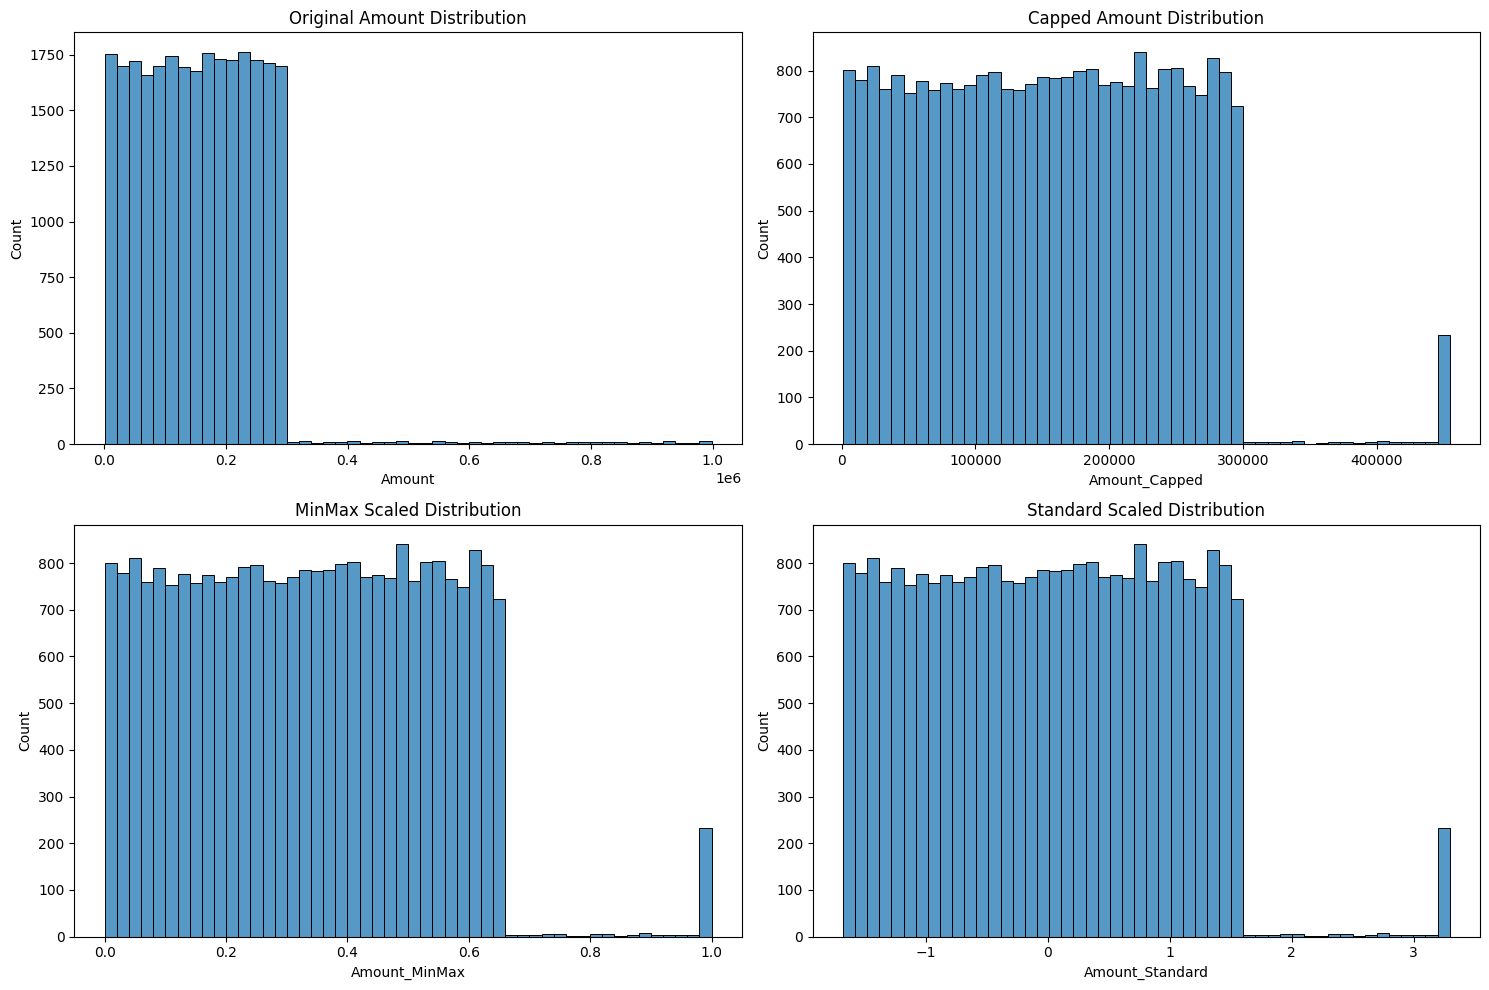

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Original Distribution
sns.histplot(df['Amount'], bins=50, ax=axes[0,0])
axes[0,0].set_title('Original Amount Distribution')

# Capped Distribution
sns.histplot(df_scaled['Amount_Capped'], bins=50, ax=axes[0,1])
axes[0,1].set_title('Capped Amount Distribution')

# MinMax Scaled Distribution
sns.histplot(df_scaled['Amount_MinMax'], bins=50, ax=axes[1,0])
axes[1,0].set_title('MinMax Scaled Distribution')

# Standard Scaled Distribution
sns.histplot(df_scaled['Amount_Standard'], bins=50, ax=axes[1,1])
axes[1,1].set_title('Standard Scaled Distribution')

plt.tight_layout()
plt.show()

In [41]:
# 6. Show summary statistics for each version
print("\nSummary Statistics:")
print("\nOriginal Amount:")
print(df['Amount'].describe())
print("\nCapped Amount:")
print(df_scaled['Amount_Capped'].describe())
print("\nMinMax Scaled Amount:")
print(df_scaled['Amount_MinMax'].describe())
print("\nStandard Scaled Amount:")
print(df_scaled['Amount_Standard'].describe())


Summary Statistics:

Original Amount:
count     26052.000000
mean     156411.537425
std      103063.254287
min        1005.000000
25%       77120.250000
50%      153106.500000
75%      228050.000000
max      998077.000000
Name: Amount, dtype: float64

Capped Amount:
count     26052.000000
mean     154033.055548
std       91204.133991
min        1005.000000
25%       77120.250000
50%      153106.500000
75%      228050.000000
max      454444.625000
Name: Amount_Capped, dtype: float64

MinMax Scaled Amount:
count    26052.000000
mean         0.337483
std          0.201138
min          0.000000
25%          0.167862
50%          0.335439
75%          0.500717
max          1.000000
Name: Amount_MinMax, dtype: float64

Standard Scaled Amount:
count    2.605200e+04
mean    -3.054690e-17
std      1.000019e+00
min     -1.677895e+00
25%     -8.433201e-01
50%     -1.015933e-02
75%      8.115681e-01
max      3.293900e+00
Name: Amount_Standard, dtype: float64


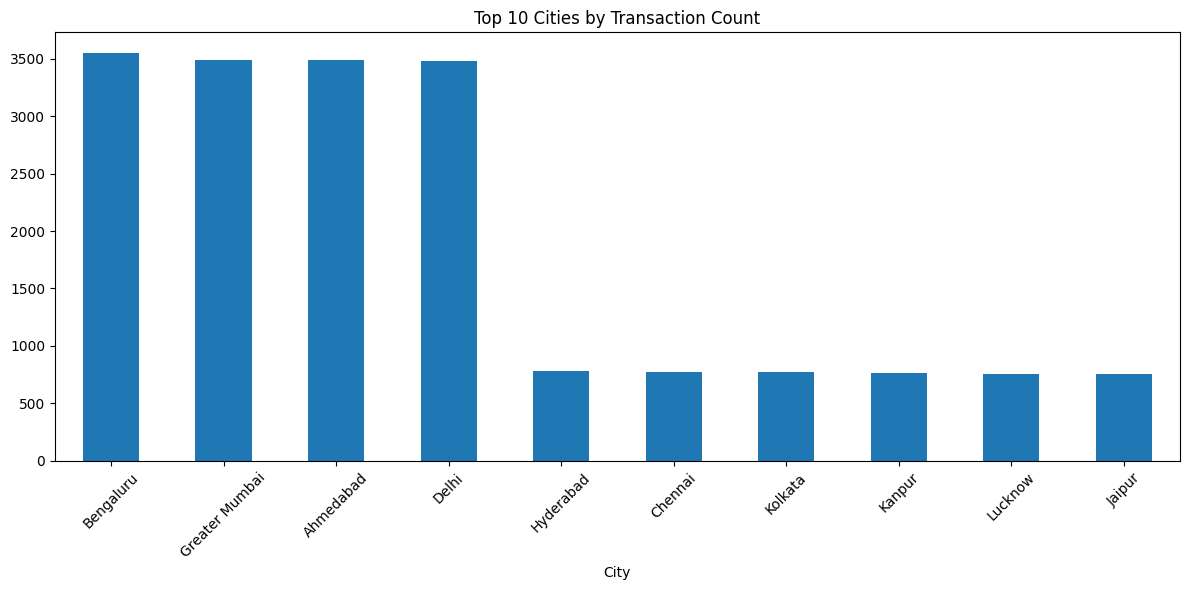


City Statistics:
Number of unique cities: 986

Top 5 cities by transaction count:
City
Bengaluru         3552
Greater Mumbai    3493
Ahmedabad         3491
Delhi             3482
Hyderabad          784
Name: count, dtype: int64


In [43]:
# 1. City Analysis
plt.figure(figsize=(12, 6))
city_counts = df['City'].value_counts().head(10)  # Top 10 cities
city_counts.plot(kind='bar')
plt.title('Top 10 Cities by Transaction Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nCity Statistics:")
print(f"Number of unique cities: {df['City'].nunique()}")
print("\nTop 5 cities by transaction count:")
print(df['City'].value_counts().head())

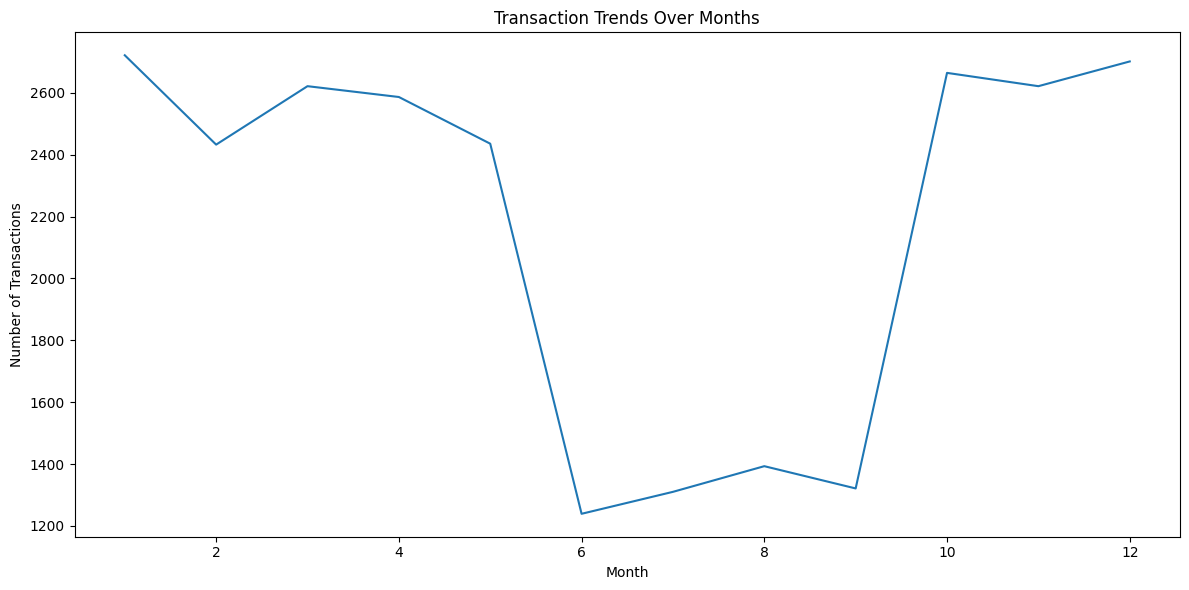


Date Range:
Start Date: 2013-10-04 00:00:00
End Date: 2015-05-26 00:00:00


In [26]:
# 2. Date Analysis
plt.figure(figsize=(12, 6))
df['Date'].dt.month.value_counts().sort_index().plot(kind='line')
plt.title('Transaction Trends Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

print("\nDate Range:")
print(f"Start Date: {df['Date'].min()}")
print(f"End Date: {df['Date'].max()}")

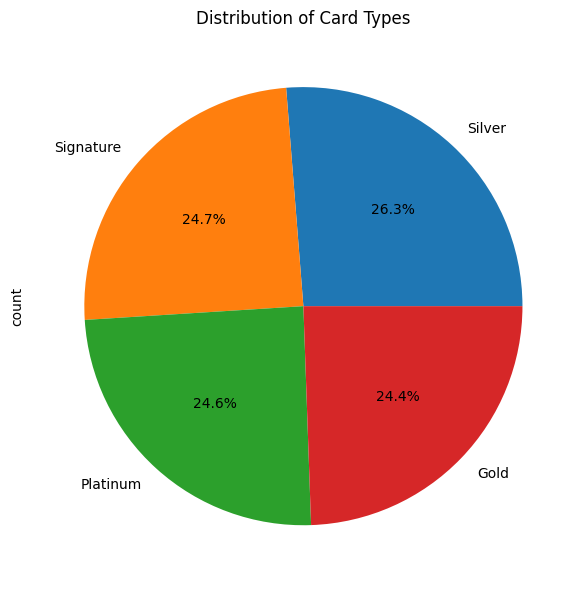


Card Type Distribution:
Card Type
Silver       6840
Signature    6447
Platinum     6398
Gold         6367
Name: count, dtype: int64


In [44]:
# 3. Card Type Analysis
plt.figure(figsize=(10, 6))
df['Card Type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Card Types')
plt.tight_layout()
plt.show()

print("\nCard Type Distribution:")
print(df['Card Type'].value_counts())

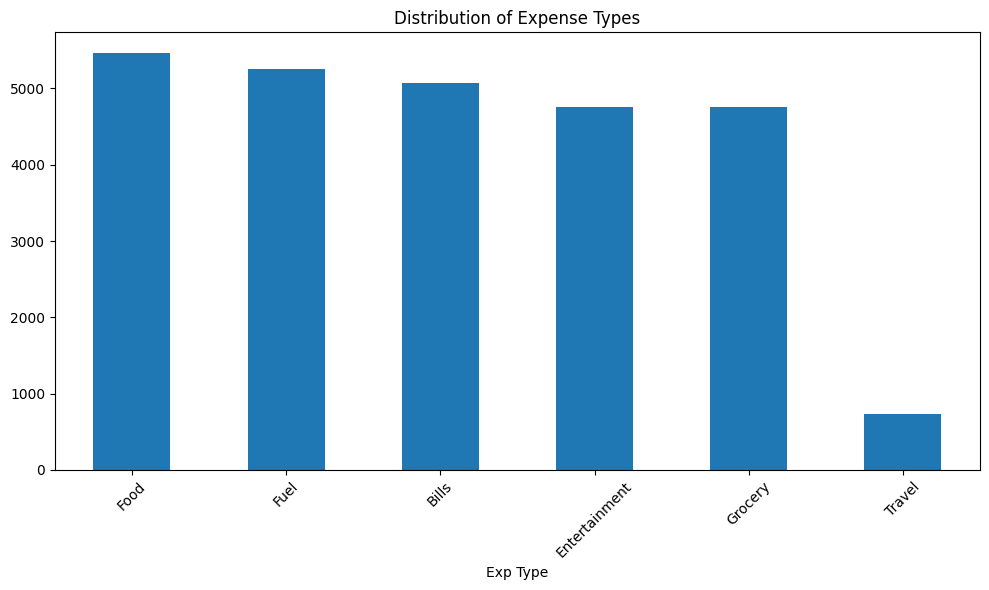


Expense Type Distribution:
Exp Type
Food             5463
Fuel             5257
Bills            5078
Entertainment    4762
Grocery          4754
Travel            738
Name: count, dtype: int64


In [28]:
# 4. Expense Type Analysis
plt.figure(figsize=(10, 6))
df['Exp Type'].value_counts().plot(kind='bar')
plt.title('Distribution of Expense Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nExpense Type Distribution:")
print(df['Exp Type'].value_counts())

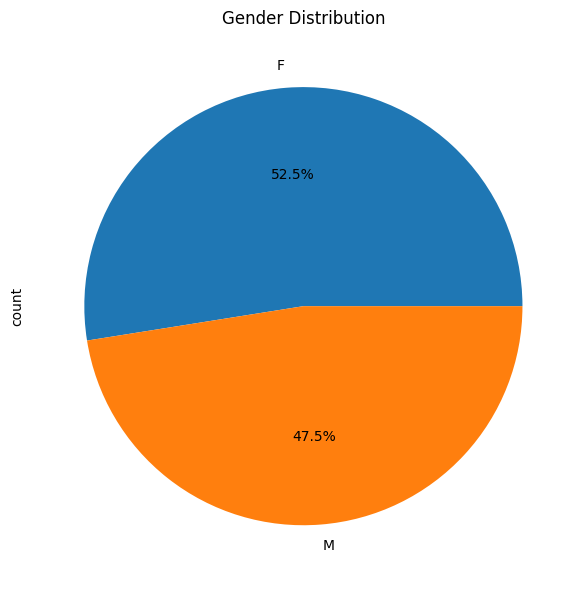


Gender Distribution:
Gender
F    13680
M    12372
Name: count, dtype: int64


In [29]:
# 5. Gender Analysis
plt.figure(figsize=(8, 6))
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

print("\nGender Distribution:")
print(df['Gender'].value_counts())

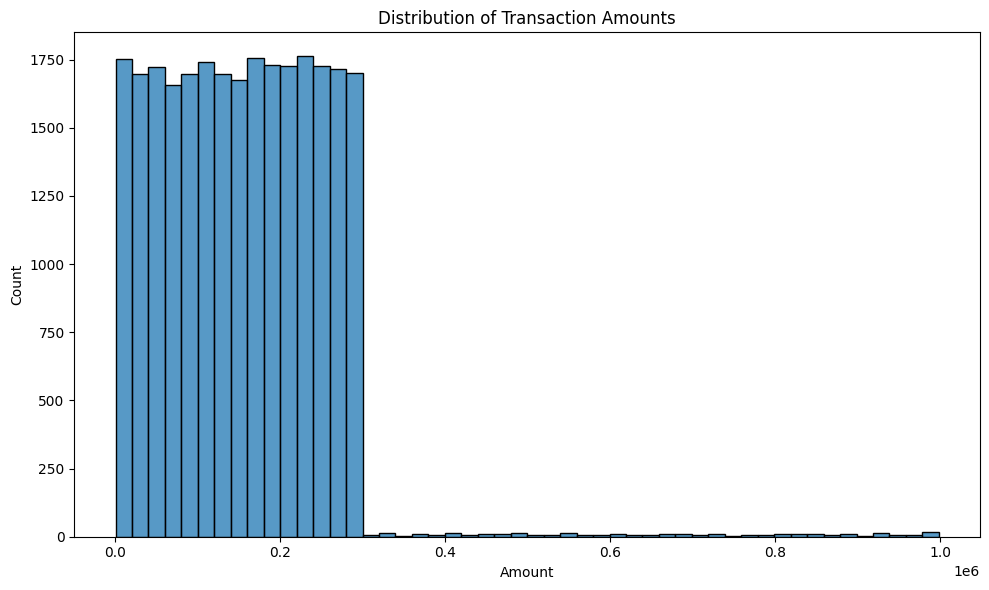


Amount Statistics:
count     26052.000000
mean     156411.537425
std      103063.254287
min        1005.000000
25%       77120.250000
50%      153106.500000
75%      228050.000000
max      998077.000000
Name: Amount, dtype: float64


In [45]:
# 6. Amount Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.tight_layout()
plt.show()

print("\nAmount Statistics:")
print(df['Amount'].describe())

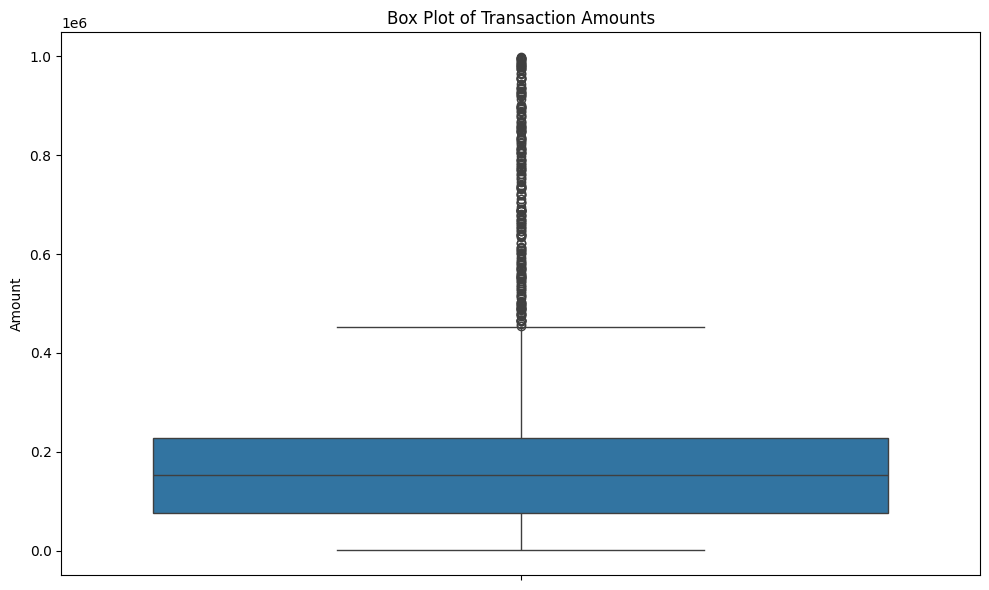

In [46]:
# Box plot for Amount
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Amount'])
plt.title('Box Plot of Transaction Amounts')
plt.tight_layout()
plt.show()

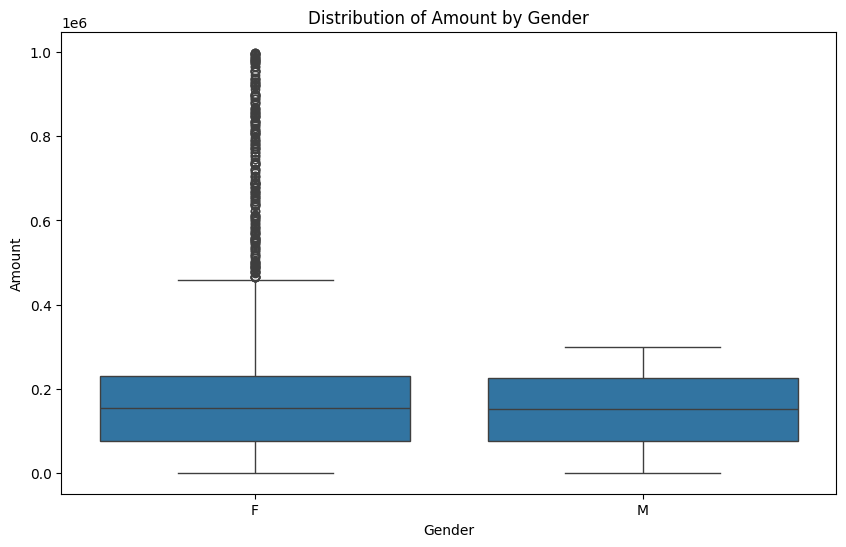

In [48]:
# 1. Amount vs Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Amount', data=df)
plt.title('Distribution of Amount by Gender')
plt.show()

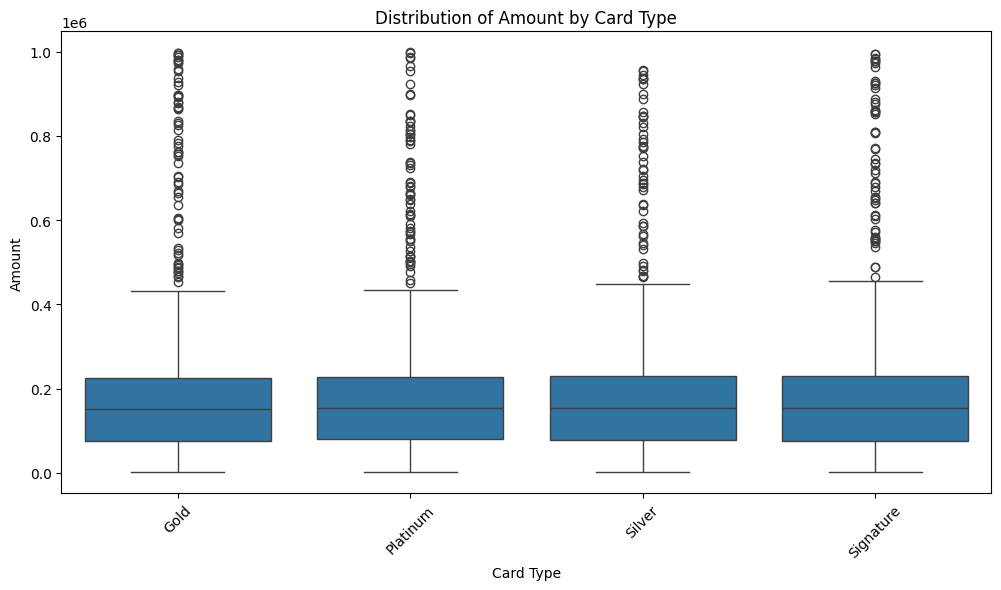

In [49]:
# 2. Amount vs Card Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Card Type', y='Amount', data=df)
plt.title('Distribution of Amount by Card Type')
plt.xticks(rotation=45)
plt.show()

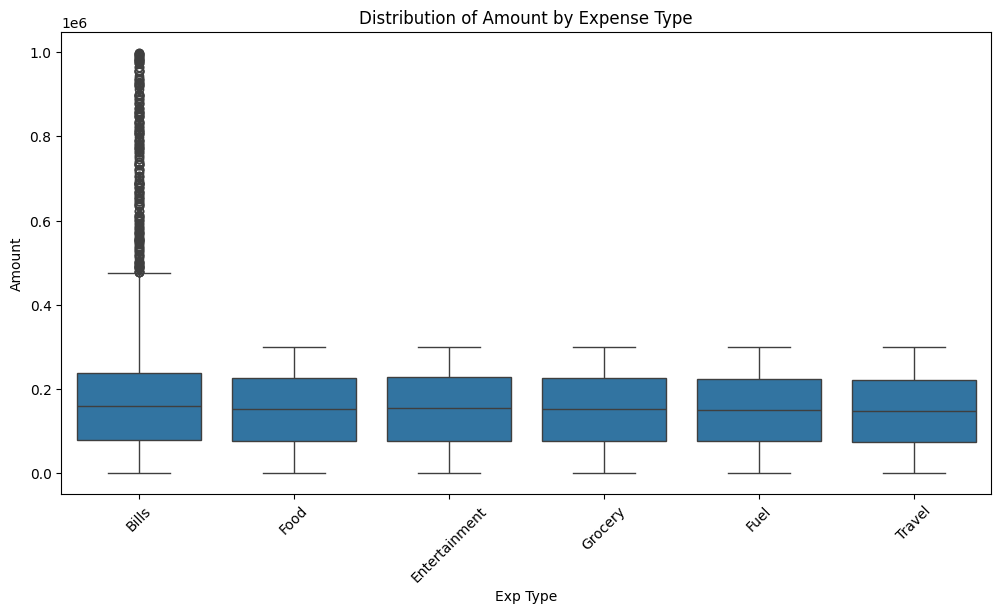

In [50]:
# 3. Amount vs Expense Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Exp Type', y='Amount', data=df)
plt.title('Distribution of Amount by Expense Type')
plt.xticks(rotation=45)
plt.show()

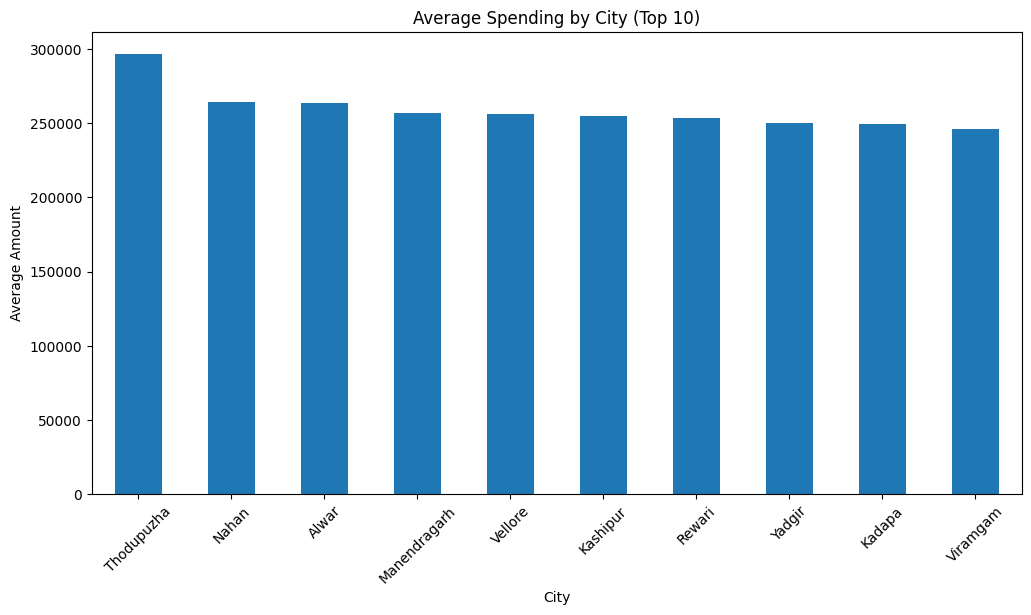

In [51]:
# 4. Average spending by City (Top 10 cities)
plt.figure(figsize=(12, 6))
city_avg = df.groupby('City')['Amount'].mean().sort_values(ascending=False).head(10)
city_avg.plot(kind='bar')
plt.title('Average Spending by City (Top 10)')
plt.xticks(rotation=45)
plt.ylabel('Average Amount')
plt.show()

<Figure size 1000x600 with 0 Axes>

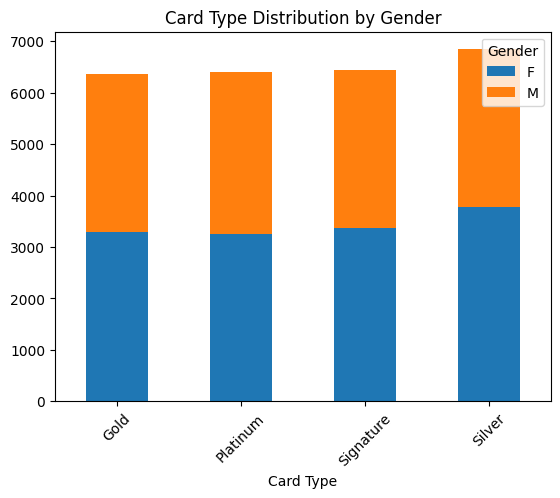

In [52]:
# 5. Card Type distribution by Gender
plt.figure(figsize=(10, 6))
pd.crosstab(df['Card Type'], df['Gender']).plot(kind='bar', stacked=True)
plt.title('Card Type Distribution by Gender')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

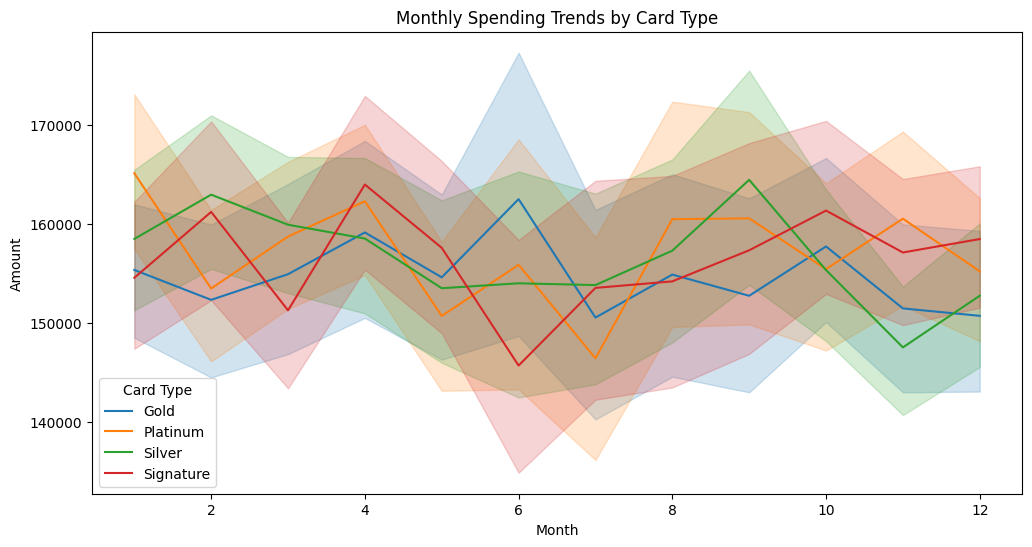

In [54]:
# 7. Monthly spending trends by Card Type
df['Month'] = df['Date'].dt.month
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='Amount', hue='Card Type')
plt.title('Monthly Spending Trends by Card Type')
plt.show()

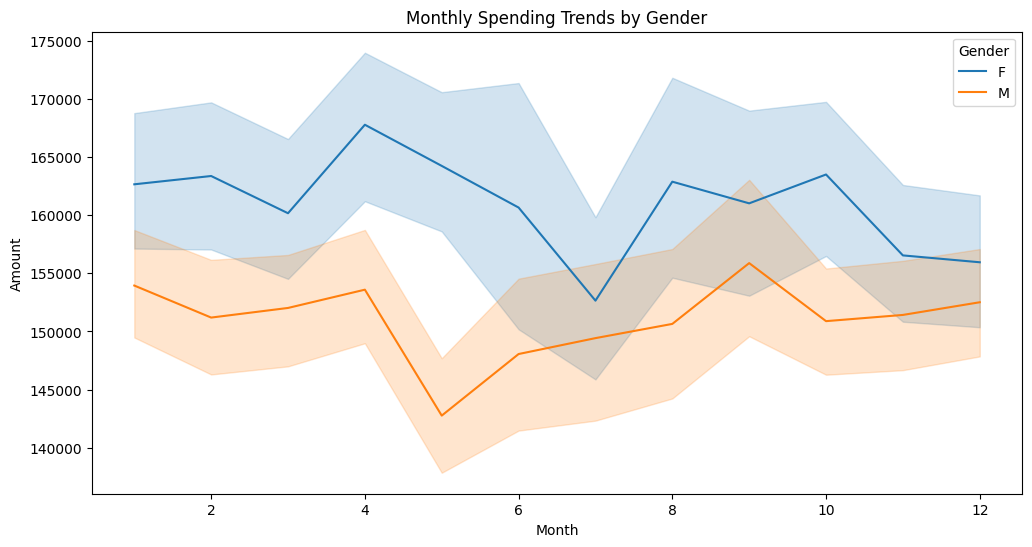

In [55]:
# 8. Monthly spending trends by Gender
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='Amount', hue='Gender')
plt.title('Monthly Spending Trends by Gender')
plt.show()

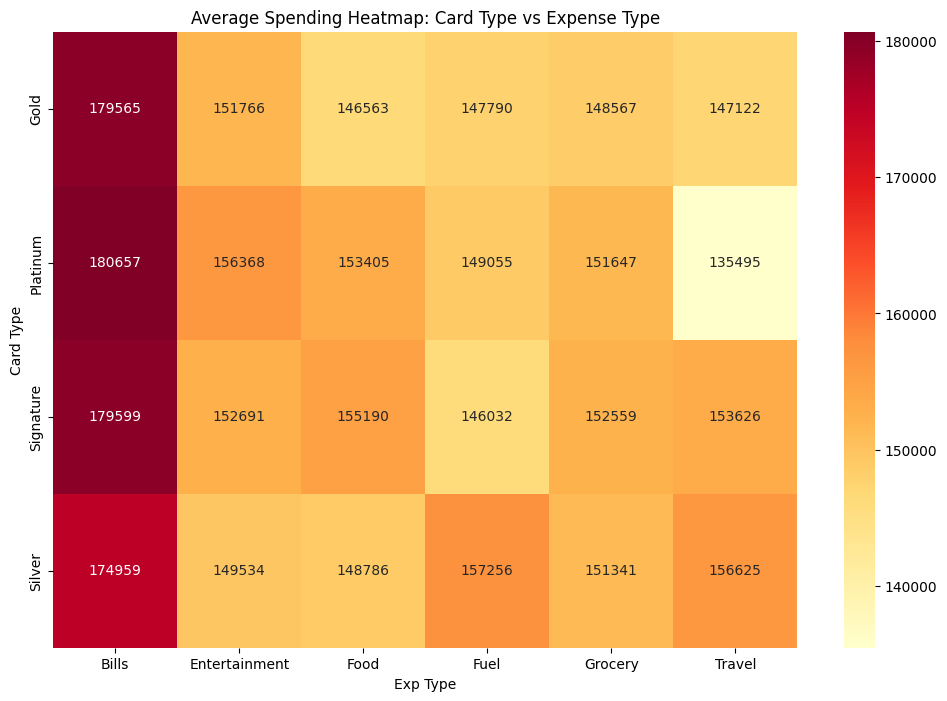

In [56]:
# 9. Heatmap of spending patterns
# Create pivot table for day of week vs hour
plt.figure(figsize=(12, 8))
spending_by_category = pd.pivot_table(df, 
                                    values='Amount',
                                    index='Card Type',
                                    columns='Exp Type',
                                    aggfunc='mean')
sns.heatmap(spending_by_category, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Average Spending Heatmap: Card Type vs Expense Type')
plt.show()


Correlation Analysis:


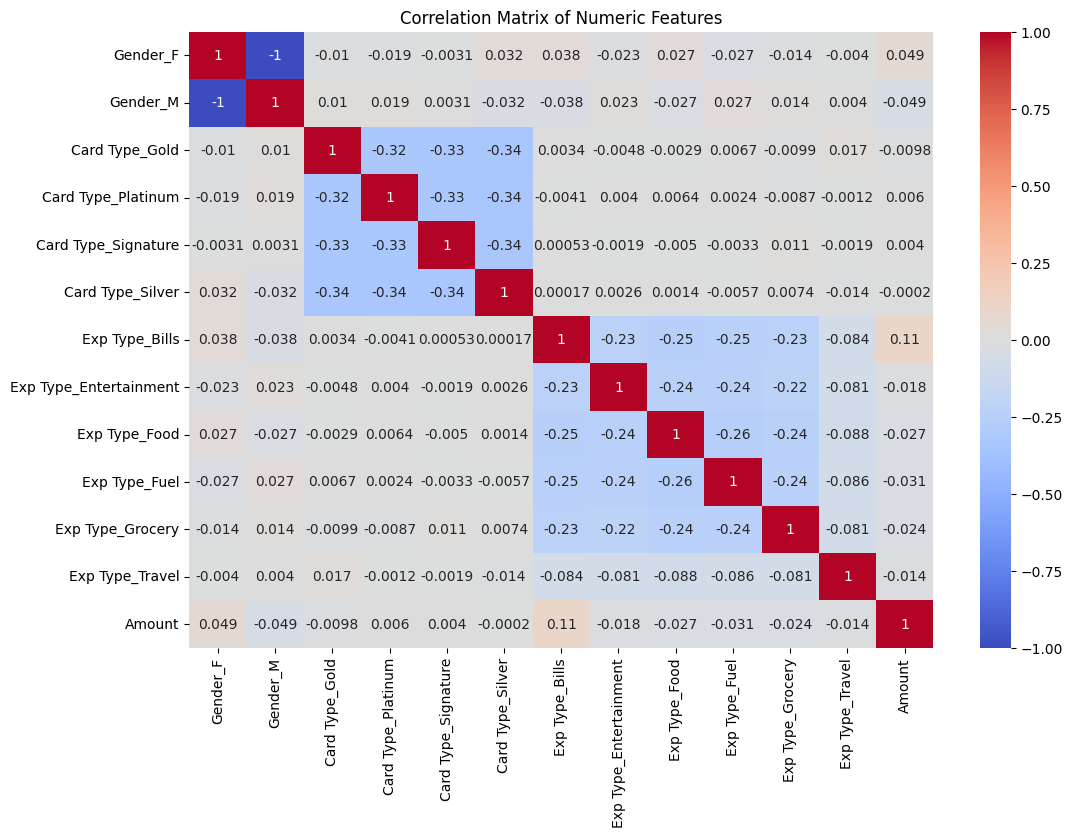

In [58]:
# 10. Statistical Analysis
print("\nCorrelation Analysis:")
# Convert categorical variables to numeric for correlation analysis
df_numeric = pd.get_dummies(df[['Gender', 'Card Type', 'Exp Type']])
df_numeric['Amount'] = df['Amount']

# Calculate and show correlation matrix
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [59]:
# 11. Statistical Summary by Groups
print("\nAmount Statistics by Gender:")
print(df.groupby('Gender')['Amount'].describe())

print("\nAmount Statistics by Card Type:")
print(df.groupby('Card Type')['Amount'].describe())

print("\nAmount Statistics by Expense Type:")
print(df.groupby('Exp Type')['Amount'].describe())


Amount Statistics by Gender:
          count           mean            std     min       25%       50%  \
Gender                                                                      
F       13680.0  161206.946637  115965.163236  1005.0  77128.50  154797.0   
M       12372.0  151109.145086   86282.544283  1018.0  77102.25  151242.0   

              75%       max  
Gender                       
F       230407.75  998077.0  
M       225900.00  299981.0  

Amount Statistics by Card Type:
            count           mean            std     min       25%       50%  \
Card Type                                                                     
Gold       6367.0  154631.621800  105800.484508  1038.0  74389.50  150431.0   
Platinum   6398.0  157492.813223  102051.710950  1005.0  79394.75  154215.0   
Signature  6447.0  157133.721886  104385.788773  1024.0  76500.00  153972.0   
Silver     6840.0  156376.273830  100127.272753  1018.0  78180.00  154028.5   

                 75%       max  


In [60]:
# ANOVA test for Card Type
card_types = [group['Amount'].values for name, group in df.groupby('Card Type')]
f_statistic, p_value = stats.f_oneway(*card_types)
print("\nANOVA Test Results for Card Type:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")


ANOVA Test Results for Card Type:
F-statistic: 0.9735
p-value: 0.4041


In [61]:

# T-test for Gender
male_amounts = df[df['Gender'] == 'M']['Amount']
female_amounts = df[df['Gender'] == 'F']['Amount']
t_statistic, p_value = stats.ttest_ind(male_amounts, female_amounts)
print("\nT-test Results for Gender:")
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")


T-test Results for Gender:
t-statistic: -7.9064
p-value: 0.0000


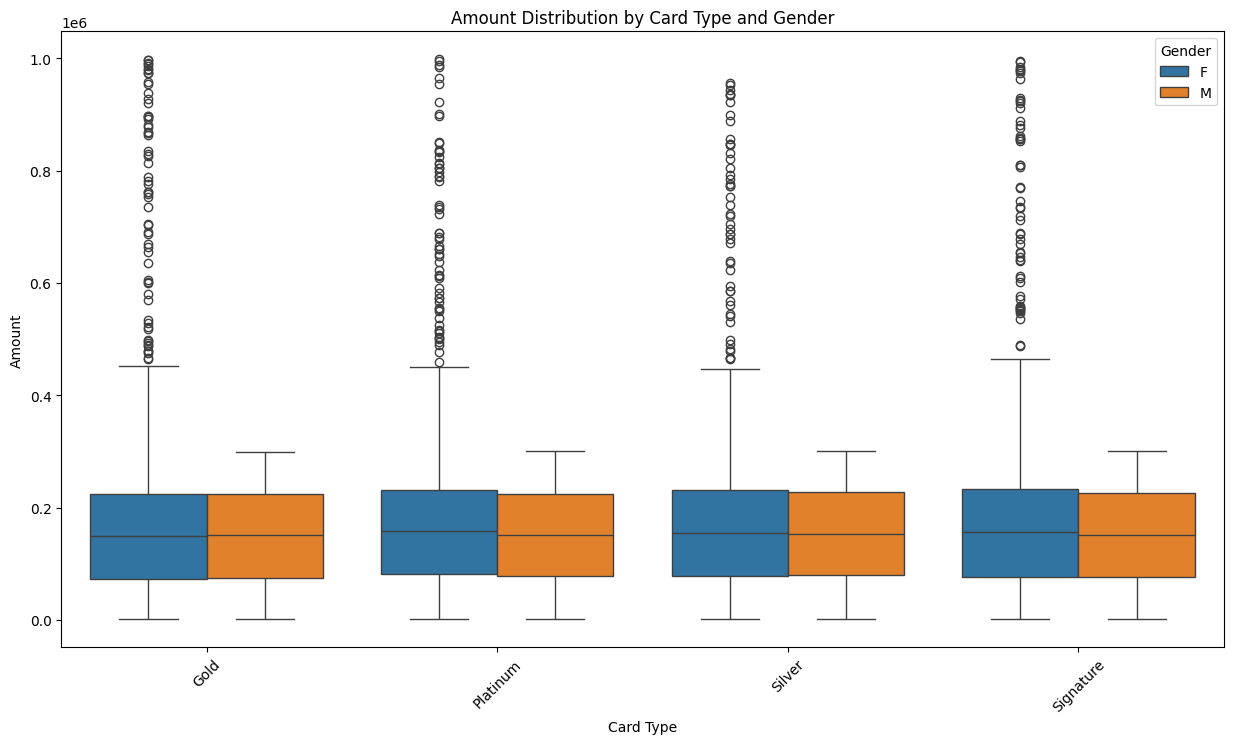

In [62]:
# 13. Multi-dimensional analysis
plt.figure(figsize=(15, 8))
sns.boxplot(x='Card Type', y='Amount', hue='Gender', data=df)
plt.title('Amount Distribution by Card Type and Gender')
plt.xticks(rotation=45)
plt.show()

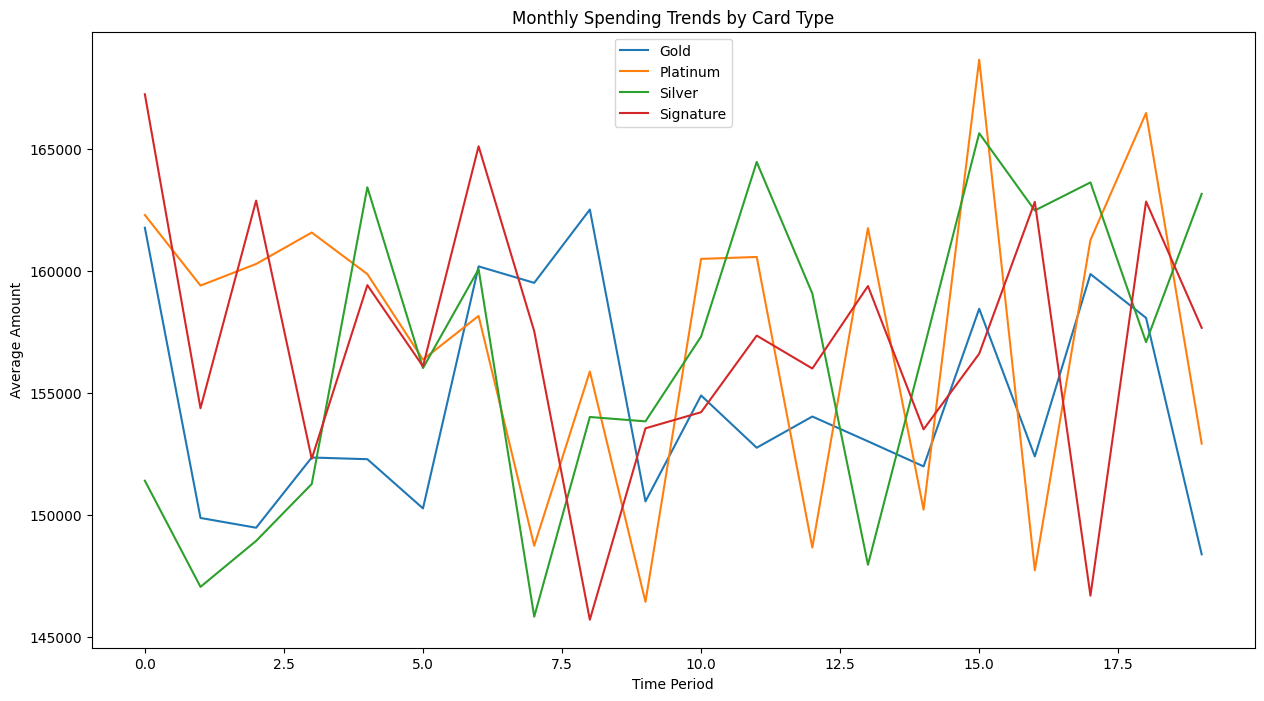

In [63]:
# 14. Spending patterns over time
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
monthly_spending = df.groupby(['Year', 'Month', 'Card Type'])['Amount'].mean().reset_index()

plt.figure(figsize=(15, 8))
for card_type in df['Card Type'].unique():
    data = monthly_spending[monthly_spending['Card Type'] == card_type]
    plt.plot(range(len(data)), data['Amount'], label=card_type)
plt.title('Monthly Spending Trends by Card Type')
plt.xlabel('Time Period')
plt.ylabel('Average Amount')
plt.legend()
plt.show()

In [67]:
# 1. Data Preprocessing
# Encode categorical variables
le = LabelEncoder()
df_ml = df.copy()
df_ml['Gender'] = le.fit_transform(df['Gender'])
df_ml['Card_Type'] = le.fit_transform(df['Card Type'])
df_ml['Exp_Type'] = le.fit_transform(df['Exp Type'])
df_ml['City'] = le.fit_transform(df['City'])

In [68]:
# Extract temporal features
df_ml['Month'] = df['Date'].dt.month
df_ml['Year'] = df['Date'].dt.year
df_ml['DayOfWeek'] = df['Date'].dt.dayofweek


In [80]:
# 1. Product Development & Card Offerings Model
def create_card_recommendation_model():
    # Feature engineering for card recommendations
    features = ['Gender', 'Amount', 'Exp_Type', 'Month', 'City']
    X = df_ml[features]
    y = df_ml['Card_Type']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost classifier
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    print("\nCard Recommendation Model Performance:")
    print(classification_report(y_test, y_pred))
    
    return model

print("1. Training Card Recommendation Model...")
card_model = create_card_recommendation_model()

1. Training Card Recommendation Model...

Card Recommendation Model Performance:
              precision    recall  f1-score   support

           0       0.27      0.23      0.25      1297
           1       0.25      0.24      0.24      1254
           2       0.27      0.23      0.25      1341
           3       0.26      0.33      0.29      1319

    accuracy                           0.26      5211
   macro avg       0.26      0.26      0.26      5211
weighted avg       0.26      0.26      0.26      5211



In [81]:
# 2. Risk Management Model
def create_risk_assessment_model():
    # Calculate spending patterns and variability
    df_ml['Avg_Transaction'] = df_ml.groupby('Card_Type')['Amount'].transform('mean')
    df_ml['Std_Transaction'] = df_ml.groupby('Card_Type')['Amount'].transform('std')
    df_ml['Transaction_Ratio'] = df_ml['Amount'] / df_ml['Avg_Transaction']
    
    # Define risk levels (example threshold)
    df_ml['Risk_Level'] = pd.qcut(df_ml['Transaction_Ratio'], q=3, labels=['Low', 'Medium', 'High'])
    
    features = ['Amount', 'Avg_Transaction', 'Std_Transaction', 'Transaction_Ratio', 
                'Gender', 'Card_Type', 'Exp_Type', 'Month']
    X = df_ml[features]
    y = le.fit_transform(df_ml['Risk_Level'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print("\nRisk Assessment Model Performance:")
    print(classification_report(y_test, y_pred))
    
    return model

print("\n2. Training Risk Assessment Model...")
risk_model = create_risk_assessment_model()


2. Training Risk Assessment Model...

Risk Assessment Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       1.00      1.00      1.00      1750
           2       1.00      1.00      1.00      1721

    accuracy                           1.00      5211
   macro avg       1.00      1.00      1.00      5211
weighted avg       1.00      1.00      1.00      5211



In [82]:
# 3. Geographical Expansion Analysis
def create_geographical_analysis_model():
    # Aggregate city-level metrics
    city_metrics = df_ml.groupby('City').agg({
        'Amount': ['mean', 'count', 'std'],
        'Card_Type': 'nunique'
    }).reset_index()
    
    # Flatten column names and convert them to strings
    city_metrics.columns = ['City', 'Amount_mean', 'Amount_count', 'Amount_std', 'Card_Type_unique']
    
    # Add gender distribution
    gender_dist = df_ml.groupby('City')['Gender'].value_counts(normalize=True).unstack()
    if gender_dist.columns.dtype != 'object':
        gender_dist.columns = gender_dist.columns.astype(str)
    
    # Merge gender distribution with city metrics
    city_metrics = pd.merge(city_metrics, gender_dist, left_on='City', right_index=True, how='left')
    
    # Fill any NaN values
    city_metrics = city_metrics.fillna(0)
    
    # Ensure all column names are strings
    city_metrics.columns = city_metrics.columns.astype(str)
    
    # Normalize features (excluding the City column)
    features_for_clustering = city_metrics.drop('City', axis=1)
    
    # Normalize features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features_for_clustering)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    city_clusters = kmeans.fit_predict(features_normalized)
    
    # Add clusters back to the metrics
    city_metrics['Cluster'] = city_clusters
    
    print("\nGeographical Analysis Results:")
    print("\nNumber of cities in each cluster:")
    print(pd.Series(city_clusters).value_counts())
    
    print("\nCluster Characteristics:")
    cluster_means = city_metrics.groupby('Cluster').mean()
    print(cluster_means)
    
    print("\nGeographical Clustering Silhouette Score:", 
          silhouette_score(features_normalized, city_clusters))
    
    return kmeans, scaler, city_metrics

print("\n3. Geographical Analysis Model...")
geo_model, geo_scaler, city_metrics = create_geographical_analysis_model()


3. Geographical Analysis Model...

Geographical Analysis Results:

Number of cities in each cluster:
2    436
1    329
0    221
Name: count, dtype: int64

Cluster Characteristics:
               City    Amount_mean  Amount_count    Amount_std  \
Cluster                                                          
0        492.049774  147678.284979      4.457014  69601.963646   
1        515.376900  145771.142347      5.267477  83140.716767   
2        475.465596  154587.917002     53.518349  86837.345014   

         Card_Type_unique         0         1  
Cluster                                        
0                2.542986  0.225800  0.774200  
1                2.796353  0.725261  0.274739  
2                3.720183  0.452368  0.547632  

Geographical Clustering Silhouette Score: 0.18567058404524692


In [83]:
# 4. Customer Experience Enhancement
def create_customer_experience_model():
    # Create features for customer experience
    df_ml['Transaction_Frequency'] = df_ml.groupby('Card_Type')['Amount'].transform('count')
    df_ml['Spending_Diversity'] = df_ml.groupby('Card_Type')['Exp_Type'].transform('nunique')
    
    features = ['Amount', 'Transaction_Frequency', 'Spending_Diversity', 
                'Gender', 'Card_Type', 'Month', 'City']
    X = df_ml[features]
    
    # Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
    
    # Cluster customers
    kmeans = KMeans(n_clusters=4, random_state=42)
    customer_segments = kmeans.fit_predict(X_pca)
    
    print("\nCustomer Segmentation Silhouette Score:", 
          silhouette_score(X_pca, customer_segments))
    
    return kmeans, pca

print("\n4. Customer Experience Model...")
exp_model, exp_pca = create_customer_experience_model()


4. Customer Experience Model...

Customer Segmentation Silhouette Score: 0.4125779702054784


In [79]:
# Update the main execution
try:
    print("Training Models...")
    print("\n1. Training Card Recommendation Model...")
    card_model = create_card_recommendation_model()
    
    print("\n2. Training Risk Assessment Model...")
    risk_model = create_risk_assessment_model()
    
    print("\n3. Creating Geographical Analysis Model...")
    geo_model, geo_scaler, city_metrics = create_geographical_analysis_model()
    
    print("\n4. Creating Customer Experience Model...")
    exp_model, exp_pca = create_customer_experience_model()
    
    # Modified prediction function
    def predict_for_new_customer(customer_data):
        """
        customer_data should be a dictionary with required features
        """
        try:
            # Card recommendation
            card_features = pd.DataFrame([{k: customer_data[k] for k in ['Gender', 'Amount', 'Exp_Type', 'Month', 'City']}])
            card_pred = card_model.predict(card_features)
            
            # Risk assessment
            risk_features = pd.DataFrame([customer_data])
            risk_pred = risk_model.predict(risk_features)
            
            # Customer segment
            exp_features = exp_pca.transform(StandardScaler().fit_transform(pd.DataFrame([customer_data])))
            segment_pred = exp_model.predict(exp_features)
            
            # Get city cluster
            city = customer_data['City']
            city_cluster = None
            if city in city_metrics['City'].values:
                city_cluster = city_metrics[city_metrics['City'] == city]['Cluster'].iloc[0]
            
            return {
                'Recommended_Card': le.inverse_transform(card_pred)[0],
                'Risk_Level': le.inverse_transform(risk_pred)[0],
                'Customer_Segment': segment_pred[0],
                'City_Cluster': int(city_cluster) if city_cluster is not None else None
            }
        except Exception as e:
            print(f"Error in prediction: {str(e)}")
            return None

    # Example usage
    print("\nExample Prediction for New Customer:")
    sample_customer = {
        'Gender': 1,  # encoded
        'Amount': 5000,
        'Exp_Type': 2,  # encoded
        'Month': 6,
        'City': 10,  # encoded
        'Transaction_Frequency': 5,
        'Spending_Diversity': 3
    }
    prediction = predict_for_new_customer(sample_customer)
    if prediction:
        print("\nPrediction Results:")
        for key, value in prediction.items():
            print(f"{key}: {value}")

except Exception as e:
    print(f"An error occurred: {str(e)}")

Training Models...

1. Training Card Recommendation Model...

Card Recommendation Model Performance:
              precision    recall  f1-score   support

           0       0.27      0.23      0.25      1297
           1       0.25      0.24      0.24      1254
           2       0.27      0.23      0.25      1341
           3       0.26      0.33      0.29      1319

    accuracy                           0.26      5211
   macro avg       0.26      0.26      0.26      5211
weighted avg       0.26      0.26      0.26      5211


2. Training Risk Assessment Model...

Risk Assessment Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       1.00      1.00      1.00      1750
           2       1.00      1.00      1.00      1721

    accuracy                           1.00      5211
   macro avg       1.00      1.00      1.00      5211
weighted avg       1.00      1.00      1.00      5211


3. Creat